In [89]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import emcee
from scipy.stats import multivariate_normal as mn
%load_ext autoreload

%autoreload 2
def load(filename, **kwargs):
    """Loads GalaxyCluster object to filename using Pickle"""
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)
import sys
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as mass_richness
import CL_WL_fit_cluster_mass as fit
import CL_fiducial_mass_richness_relation as fiducial
import analysis_Mass_Richness_relation as analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model

mean:
$$
\mu(\lambda, z) = \log_{10}(M_{\rm 0}) + G_z^\mu\log_{10}\left(\frac{1 + z}{1 + z_0}\right) + G_\lambda^\mu\log_{10}\left(\frac{\lambda}{\lambda_0}\right)
$$

standard deviation:
$$
\sigma(\lambda, z) = \sigma_{\log_{10}M} + F_z^\sigma\log_{10}\left(\frac{1 + z}{1 + z_0}\right) + F_\lambda^\sigma\log_{10}\left(\frac{\lambda}{\lambda_0}\right)
$$

Conditional probability:
$$
P(\log_{10}M|\lambda, z) = \frac{1}{\sqrt{2\pi \sigma (\lambda, z)^2}}\exp{-\frac{1}{2}\left(\frac{\log_{10}M - \mu(\lambda, z)}{\sigma (\lambda, z)}\right)^2}
$$

# Data

In [90]:
data_match = load('/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/matched_redMaPPer_to_cosmodc2.pkl')
z_0 = np.mean(data_match['redshift_RedMapper'])
richness_0 = np.mean(data_match['richness_RedMapper'])
logm200c = np.log10(data_match['M200c_cosmoDC2'])
logrichness = np.log10(data_match['richness_RedMapper'])
redshift = data_match['redshift_RedMapper']
data_mcmc = [logm200c, redshift, logrichness]

# Likelihood

Log-likelihood:
$$
\ln L_{\rm un-binned} = \sum_{i = 1} \ln P(\log_{10}M_{200c,i}|\lambda_i, z_i)
$$

In [91]:
WL_Mlambda = mass_richness.WL_Mass_Richness(logm=None, logm_err=None, 
                                             richness=None, richness_err=None, 
                                             z=None, z_err=None,
                                             richness_individual=data_match['richness_RedMapper'], 
                                             z_individual=data_match['redshift_RedMapper'], 
                                             n_cluster_per_bin=None, weights_individual=None)
WL_Mlambda.set_pivot_values(analysis.z0, analysis.richness0)

In [92]:
WL_Mlambda.logm_individual=logm200c

In [93]:
def lnL(theta):
    return WL_Mlambda.lnLikelihood_individual_masses(logm200c, 10**logrichness, redshift, theta)

In [94]:
lnL([14.1,0.0,1,0.1,0.,0.])

-3431.989156082203

# MCMC

In [95]:
initial = [14.1,0.0,1,0.1,0.,0.]
pos = initial + 0.001 * np.random.randn(70, len(initial))
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL)
sampler.run_mcmc(pos, 500, progress=True);

  3%|▎         | 14/500 [00:01<00:59,  8.14it/s]/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/CL_Likelihood_for_Mass_richness_relation.py:113: RuntimeWarning: divide by zero encountered in log
  richness_individual: array
100%|██████████| 500/500 [00:57<00:00,  8.70it/s]


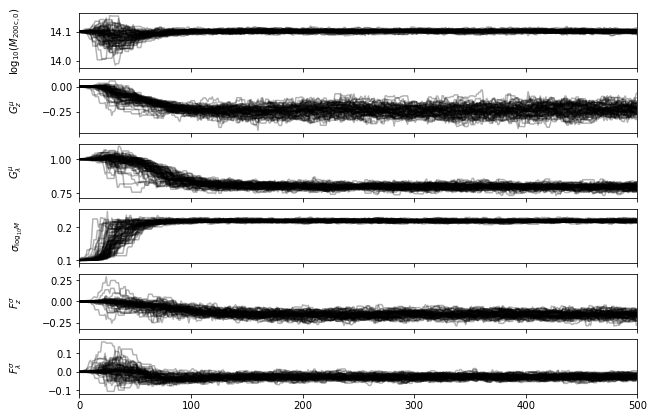

In [96]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
labels = [r'$\log_{10}(M_{\rm 200c,0})$', r'$G_z^\mu$', r'$G_\lambda^\mu$', r'$\sigma_{\log_{10}M}$', r'$F_z^\sigma$', r'$F_\lambda^\sigma$']
samples = sampler.get_chain()
for i in range(6):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [97]:
flat_samples = sampler.get_chain(discard=0, thin=1,flat=True)

In [98]:
def mu_sigma_parameters(samples = None, labels = None):
    mu = {labels[i] : np.mean(samples[:,i]) for i in range(len(labels))}
    sigma = {labels[i] : np.std(samples[:,i]) for i in range(len(labels))}
    return mu, sigma

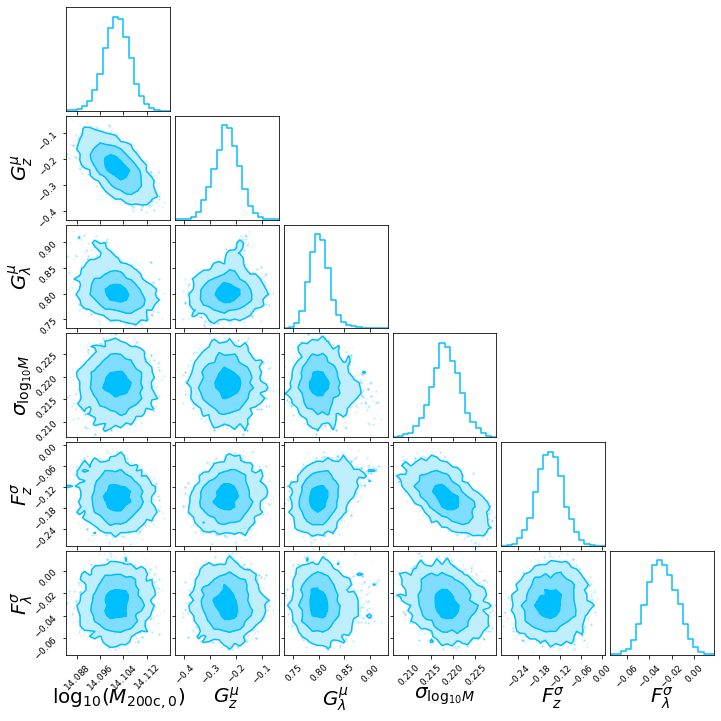

In [99]:
import corner
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
bins = 20
fig, axs = plt.subplots(len(labels), len(labels), figsize = (10,10))
for i in range(len(labels)):
    for j in range(len(labels)):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 9)
fig = corner.corner(
    flat_samples[6000:],
    bins=bins, levels=(sigma1, sigma2, sigma3),
    fig = fig,
                        smooth1d=False,smooth=False,plot_datapoints=True,
                  fill_contours=True,labels = labels,
                         
    color='deepskyblue',
    label_kwargs={"fontsize": 20},
                  use_math_text=True,
                        plot_density=False,
                        max_n_ticks = 5,
);

# Best fit

In [87]:
mu_p, sigma_p = mu_sigma_parameters(samples = flat_samples, labels = labels)

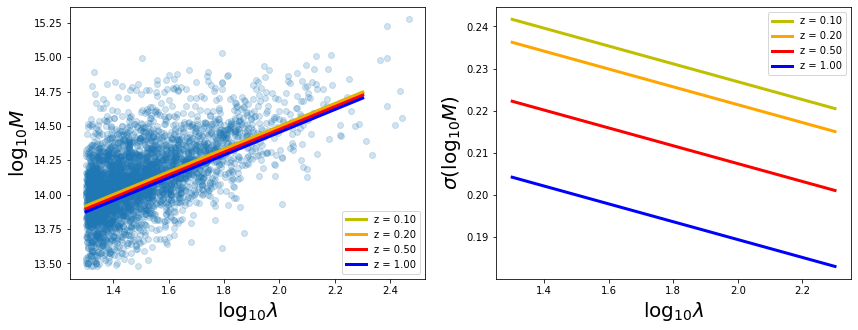

In [88]:
richness = np.linspace(20, 200, 100)
c = ['y', 'orange', 'r', 'b',]
fig, ax = plt.subplots(1, 2, figsize = (14,5))
ax[0].scatter(logrichness, logm200c, alpha = .2)
for i, z in enumerate([.1, .2, .5, 1]):
    mu = mu_logM_lambda(z, np.log10(richness), mu_p[r'$\log_{10}(M_{\rm 200c,0})$'], mu_p[r'$G_z^\mu$'], mu_p[r'$G_\lambda^\mu$'])
    sigma = sigma_logM_lambda(z, np.log10(richness), mu_p[r'$\sigma_{\log_{10}M}$'], mu_p[r'$F_z^\sigma$'], mu_p[r'$F_\lambda^\sigma$'])
    ax[0].plot(np.log10(richness), mu, c = c[i] , label = f'z = {z:.2f}', linewidth = 3)
    ax[0].legend()
    ax[1].plot(np.log10(richness), sigma, c = c[i] , label = f'z = {z:.2f}', linewidth = 3)
    ax[1].legend()
    ax[0].set_ylabel(r'$\log_{10}M$', fontsize = 20)
    ax[1].set_ylabel(r'$\sigma (\log_{10}M)$', fontsize = 20)
for i in range(2):
    ax[i].set_xlabel(r'$\log_{10}\lambda$', fontsize = 20)